# Lab 4 - Monte Carlo Control in Blackjack game

## 1. Objectives

In this lab, we will:

1. Understand how Monte Carlo methods can be used to estimate value functions from experience, without knowing the transition probabilities of the environment.

2. Model the Blackjack game as an episodic Markov Decision Process (MDP) with terminal rewards.

3. Implement first-visit Monte Carlo policy evaluation to estimate state-value and action-value functions.

4. Apply Monte Carlo control to learn an optimal policy for Blackjack.

5. Address the exploration problem by using exploring starts and $\varepsilon$-soft policies.

6. Study off-policy Monte Carlo learning and understand how a target policy can be evaluated using data generated by a different behavior policy. Implement importance sampling (ordinary and weighted) to correct the distribution mismatch in off-policy learning.

-------------------

## 2. Blackjack game

Blackjack is a card game played between a **player** and a **dealer**. The goal is to obtain a hand value as close as possible to 21, without exceeding it.

- Card values
    - Number cards (2–10): face value
    - Face cards (J, Q, K): value 10
    - Ace (A): value 1 or 11
        - The Ace (A) is a special card in Blackjack because it can take two possible values: 1 or 11.
        - When an Ace is counted as 11 without making the hand exceed 21, we say the hand has a usable ace.
        - If counting the Ace as 11 would cause the total to exceed 21, the Ace is automatically counted as 1.
        - This choice is not an action taken by the player; it is an automatic rule of the game that always favors avoiding a bust.


- Game flow
    - The game starts by giving the player an initial hand and showing one visible card for the dealer.
        - The player then plays first and repeatedly chooses between:
            - **Hit**: draw one additional card
            - **Stick**: stop drawing cards
        - If the player’s total exceeds 21 at any time, the episode ends immediately with a loss.
        - After the player sticks, the dealer plays:
            - The dealer must hit until the hand value is at least 17
            - Then the dealer sticks

- Outcome and rewards
   - Player wins if their final hand value is higher than the dealer’s without busting.
   - Player loses if they bust or if the dealer has a higher hand.
   - A draw (tie) gives zero reward.

**Next, we will model the Blackjack game as an episodic Markov Decision Process (MDP) with terminal rewards.**

### 2.0 Imports and global settings

In [218]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np

# Reproducibility
rng = np.random.default_rng(0)

### 2.1 Blackjack environment (State, Action, Episode, Rewards)

1. State is a summary of the game 
$$
s=(p,d,u)
$$
where
    - $p =$ player's current sum 
    - $d =$ dealer’s showing card (1–10)
    - $u =$ usable ace indicator (0/1)

  
2. Player's action :
    - STICK = 0
    - HIT = 1
      
3. Episode ends when:
    - player busts (sum > 21), or
    - player sticks and dealer finishes their fixed policy (hit until 17)

4. Rewards:
    - player bust: −1
    - else at terminal after dealer plays: win +1, lose −1, draw 0
    - Here, intermediate rewards are 0; only terminal reward matters. 

5. Uniform card draws: Here in this lab, we assume a uniform draw of cards to simplify the environment and preserve the Markov property.
    - With uniform draws: future cards are independent of the past; the state $(p,d,u)$ is sufficient.
    - With a real deck: card probabilities depend on the history of drawn cards; therefore, the state $(p,d,u)$ is no longer Markov.

In [219]:
# In Blackjack the player has two possible decisions:
STICK = 0  # STICK: stop drawing cards (end the player's turn)
HIT = 1  # HIT: draw one more card
ACTIONS = [STICK, HIT]  # the list of all valid actions

We now define a function that draws a card with a value in $\{1,2,\cdots,10\}$.
    
1. The value 1 represents an Ace.
2. The value 10 represents any 10, Jack, Queen, or King, all of which are treated as having value 10.

**Important** To simplify the environment and make it suitable for modeling as a Markov Decision Process (MDP), we assume that cards are drawn uniformly from this set. This removes the need to track the remaining deck composition and allows the transition dynamics to depend only on the current state.

In [220]:
def draw_card(rng: np.random.Generator) -> int:
    """Draw a card value in {1,...,10}. Face cards have value 10."""
    return int(rng.integers(1, 11))


Now we define a function `usable_ace(hand)` to detect whether an Ace in hand can be trated as “11”, which means, it is a usable ace.

Recall that a “usable ace” means: the hand contains an Ace (1 in hand) and we can treat that Ace as 11 instead of 1 without going over 21. 

Examples:
- hand = [1, 7] $\rightarrow$ sum(hand)=8 $\rightarrow$ 8+10=18 <= 21 $\rightarrow$ usable ace = True
- hand = [1, 7, 5] $\rightarrow$ sum=13 $\rightarrow$ 13+10=23 > 21 $\rightarrow$ usable ace = False (Here ace must be counted as 1)


In [221]:
def usable_ace(hand: list[int]) -> bool:
    """Return True if hand has an ace (value 1) that can be counted as 11 without busting."""
    return (1 in hand) and (sum(hand) + 10 <= 21)  # noqa: PLR2004


This `sum_hand(hand)` function returns the hand’s effective score under Blackjack rules:

1. If there is a usable ace, count one ace as 11 (add 10).
2. Otherwise, just return the raw sum.

Why “best” sum? Since Blackjack players always prefer the highest total $\leq$ 21.


In [222]:
def sum_hand(hand: list[int]) -> int:
    """Return best (highest) sum <=21 if possible by counting usable ace as 11. Otherwise return the raw sum."""
    s = sum(hand)
    if usable_ace(hand):
        return s + 10
    return s

Now we define `is_bust(hand)` function to check if we exceed 21. 

In [223]:
def is_bust(hand: list[int]) -> bool:
    """Return True if hand sum exceeds 21."""
    return sum_hand(hand) > 21  # noqa: PLR2004


Now we define `score(hand)` for the terminal “value” of a hand. It returns a “hand score” used at the end of a game:

1. If bust: score = 0 (player is effectively dead)
2. Else: score = effective sum

In [224]:
def score(hand: list[int]) -> int:
    """Terminal score is 0 if bust otherwise sum_hand."""
    return 0 if is_bust(hand) else sum_hand(hand)

Now we define `initial_hands(rng)` to start a new episode (Environment reset).

It creates the initial state of a Blackjack episode:

- player starts with 2 cards

- dealer starts with 2 cards

The environment internally keeps both dealer cards, but the agent will only observe one (typical Blackjack rule: one dealer card is face-up).

In [225]:
def initial_hands(rng: np.random.Generator) -> tuple[list[int], list[int]]:
    """Start of a Blackjack episode.

    - Player draws 2 cards
    - Dealer draws 2 cards, but we only "observe" dealer[0]
    """
    player = [draw_card(rng), draw_card(rng)]
    dealer = [draw_card(rng), draw_card(rng)]
    return player, dealer

Now we define the state representation for the player, which is the RL agent.

We convert the full hands (lists of cards) into a state tuple $(p, d, u)$, where

1. `p = sum_hand(player)`, which is Player’s current total under Blackjack rules (Ace possibly counted as 11).
2. `d = dealer[0]`, which is Dealer’s visible card (the one face-up).
3. `u = int(usable_ace(player))`, which is a binary feature : 1 if the player has a usable ace; 0 otherwise


In [226]:
def obs(player: list[int], dealer: list[int]) -> tuple[int, int, int]:
    """Convert internal hands into tabular state (p, d, u).

    Args:
        player: list of player's cards
        dealer: list of dealer's cards

    Returns:
        (p, d, u): p = player's sum, d = dealer's visible card

    """
    p = sum_hand(player)
    d = dealer[0]
    u = int(usable_ace(player))
    return (p, d, u)

### 2.2 Blackjack step function

In reinforcement learning, an environment step function typically implements: 
$$
(S_{t+1}, r_{t+1}, \text{done})=\text{step}(s_t, a_t)
$$
where 
1. the input are the current state (here: `(player, dealer)`) and an action `(HIT or STICK)`; 
2. and the output are the updated state `(player, dealer)`; the reward for this transition and a boolean `done` indicating whether the episode ended.

In Blackjack, 
1. If the player hits, the game may continue (unless the player busts).
2. If the player sticks, the dealer finishes playing, and the episode ends immediately.

In [227]:
def step(
    player: list[int],
    dealer: list[int],
    action: int,
    rng: np.random.Generator,
) -> tuple[tuple[list[int], list[int]], int, bool]:
    """Take action from current state.

    Args:
        player: list of player's cards
        dealer: list of dealer's cards
        action: HIT or STICK
        rng: random generator used to draw cards

    Returns:
        next_state: (player's cards, dealer's cards)
        reward: -1 (lose), 0 (draw), +1 (win)
        done: True if episode ended

    """
    if action == HIT:
        player.append(
            draw_card(rng),
        )

        if is_bust(player):
            return (
                (player, dealer),
                -1,
                True,
            )
        return (
            (player, dealer),
            0,
            False,
        )

    while sum_hand(dealer) < 17:  # noqa: PLR2004
        dealer.append(draw_card(rng))

    ps = score(player)
    ds = score(dealer)

    if ds == 0 or ps > ds:
        reward = 1
    elif ps < ds:
        reward = -1
    else:
        reward = 0

    return (player, dealer), reward, True

-------------------

## 3. First-visit Monte Carlo method to estimate state-value functions

### 3.1 Episode generation (core for Monte Carlo)

Monte Carlo methods learn from complete episodes.
So we need a function that:

1. starts a new game,

2. follows a policy to generate $(S_t, A_t)$ pairs until terminal,

3. returns the whole episode + terminal reward.



**Exercise 1.** Write a function `generate_episode` that simulates one complete Blackjack game (one episode) using a input policy. 
The Args of this function `generate_episode` are 
1. `policy_fn` the input policy, which is a function that takes a state $s$ and returns an action: `HIT` (1) or `STICK` (0)
2. `rng`, which is a random generator for drawing cards (so results are reproducible).

The outputs of this function `generate_episode` are
1. `episode`: which is a list like $[(S_0, A_0), (S_1, A_1), ..., (S_{T-1}, A_{T-1})]$
2. `G`, which is the terminal return (final reward) in $\{-1, 0,1\}$ (lose, draw, win) since in our simplified Blackjack: intermediate rewards are 0, only the final outcome matters. 

*Remark.* In Blackjack, not all states are equally important for decision-making. When the player’s sum is below 12, hitting is always safe, since even the largest possible card (value 10) cannot make the player bust.

As a result, there is no real choice to make in these states, and the player should always hit. For this reason, we simplify the problem by: forcing the action HIT when the player’s sum $p<12$,and only learning decisions for states with $p=12,…,21$.

This reduces the number of states we need to consider, speeds up learning, and does not change the optimal behavior.

In [228]:
from collections.abc import Callable


def generate_episode(
    policy_fn: Callable[[tuple[int, int, int]], int],
    rng: np.random.Generator,
) -> tuple[list[tuple[tuple[int, int, int], int]], int]:
    """Generate one full episode following a given policy.

    Hint:
    - An episode is a complete Blackjack game.
    - You should repeatedly:
        1) observe the current state,
        2) choose an action using the policy,
        3) apply the action to the environment,
        4) stop when the game ends.

    Returns:
        episode: list of (state, action) pairs
        G: terminal return (final reward), in {-1, 0, 1}

    """
    player, dealer = initial_hands(rng)

    episode = []

    while True:
        s = obs(player, dealer)

        a = HIT if s[0] < 12 else policy_fn(s)  # noqa: PLR2004

        episode.append((s, a))
        (player, dealer), r, done = step(player, dealer, a, rng)

        if done:
            return episode, r

Test your `generate_episode` function with the following `always_hit_policy` :).

In [229]:
def always_hit_policy(_state: tuple[int, int, int]) -> int:
    """Return a policy that always hits."""
    return HIT


episode, G = generate_episode(always_hit_policy, rng)

print("Episode length:", len(episode))
print("Terminal return G:", G)
print("First 3 steps:", episode[:3])


Episode length: 3
Terminal return G: -1
First 3 steps: [((16, 6, 0), 1), ((20, 6, 0), 1), ((21, 6, 0), 1)]


### 3.2 Estimates the state-value function of a fixed policy $\pi$ using Monte-Carlo



In this section, we estimate the **state-value function** of a **fixed policy** using **first-visit Monte Carlo methods**.

The goal is to approximate, for each state $s$,
$$
V_\pi(s) = \mathbb{E}_\pi[G \mid S_t = s],
$$
that is, the expected final reward obtained when starting from state $s$ and following the policy $\pi$.

**Key ideas**

- We generate many **complete episodes** (full Blackjack games) by following a fixed policy.
- Each episode ends with a **terminal reward** $G \in \{-1, 0, 1\}$.
- For a given state $s$, we use the observed return $G$ as a **sample** of $V_\pi(s)$.
- In **first-visit Monte Carlo**, each state is updated **only the first time it appears in an episode**.
- The value $V_{\pi}(s)$ is estimated by the **average of all observed returns** from first visits to $s$.

**Important remarks** 

- This method does not require transition probabilities.
- Updates are performed **only after an episode terminates**. 
- In our Blackjack setting, all intermediate rewards are zero, so the return is simply the terminal reward. Hence, we do not code it backward because, in this Blackjack setting, the return is the same for all time steps, so a backward pass brings no benefit. A forward pass is simpler and equivalent.


**Exercise 2.** Define a `mc_prediction_first_visit()` function to estimates the state-value function of a fixed given policy $\pi$. 

Recall that in the simplified setting of Blackjack that we use  in this lab: rewards are 0 during the game, only the terminal reward is nonzero, so the return $G$ is just the final outcome in {−1,0,1}. And Monte Carlo prediction approximates the expectation by averaging returns from many episodes.

The Args of `mc_prediction_first_visit()` are 
1. `num_episodes`: Number of complete Blackjack games (episodes) to simulate. Each episode is one full game, from the initial deal until the game ends. Monte Carlo methods estimate expectations by averaging over many episodes.
A larger num_episodes gives: more accurate estimates of the value function, but higher computational cost.

2. `rng`: random number generator, which is the source of randomness used to simulate the environment.

The output of `mc_prediction_first_visit()` is 

`V` a dictionary mapping each state $s$ to an estimate of $V_{\pi}(s)$. 

A example of type `dict`:

In [230]:
grades = {"Alice": 15, "Bob": 12, "Charlie": 18}
print(grades["Alice"])  # returns 15

15


In [231]:
def target_policy(state: tuple[int, int, int]) -> int:
    """Deterministic policy: HIT if player's sum < 20 else STICK."""
    p, _d, _u = state
    return HIT if p < 20 else STICK  # noqa: PLR2004


In [232]:
def mc_prediction_first_visit(
    num_episodes: int = 200_000,
    rng: np.random.Generator = rng,
) -> dict:
    """First-visit Monte Carlo prediction for a fixed policy.

    Goal:
    - Estimate the state-value function V(s) of a given policy.
    - Use first-visit Monte Carlo: each state is updated at most once per episode.

    Args:
        num_episodes: number of episodes to sample
        rng: random generator used to draw cards

    Returns:
        V: dict mapping state -> estimated value

    """
    V = defaultdict(float)
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)

    def pi(s: tuple[int, int, int]) -> int:
        return target_policy(s)

    for _ in range(num_episodes):
        episode, G = generate_episode(pi, rng)
        visited_states = set()

        for s, _a in episode:
            p, _d, _u = s

            if p < 12:  # noqa: PLR2004
                continue

            if s not in visited_states:
                visited_states.add(s)
                returns_sum[s] += G
                returns_count[s] += 1
                V[s] = returns_sum[s] / returns_count[s]
    return V


Now we check if `mc_prediction_first_visit` is correctly defined. 

In [233]:
V = mc_prediction_first_visit(num_episodes=10000, rng=rng)
print(type(V), len(V))

s_test = (20, 10, 0)

print(V[s_test])

<class 'collections.defaultdict'> 200
0.6234567901234568


--------------------------------

## 4. Apply Monte Carlo control to learn an optimal policy for Blackjack (with exploring starts).

In this section, we move from **policy evaluation** to **policy control**.

Our goal is no longer to evaluate a fixed policy, but to **learn an (approximately) optimal policy** for Blackjack directly from experience. To do this, we use **Monte Carlo control with exploring starts**.

### Key ideas

- We estimate the **action-value function** $Q(s,a)$, which represents the expected final reward when taking action $a$ in state $s$.
- We generate many complete episodes (full Blackjack games).
- After each episode, we update $Q(s,a)$ using the observed return.
- We then **improve the policy greedily** by choosing, in each state, the action with the highest estimated $Q$-value.
- **Exploring starts** ensure that different state–action pairs are tried, by forcing the first action of each episode to be random.

This approach alternates between **evaluation** (updating $Q$) and **improvement** (updating the policy), gradually converging toward an optimal strategy.

> **This exercise is more challenging than the previous ones.**  
> It combines several ideas at once (episodes, first-visit Monte Carlo, action-values, and policy improvement).  
> **Do not be discouraged if it does not work immediately**: take it step by step, follow the hints, and focus on understanding the logic rather than writing everything at once.


**Exercise 3 ($\star$).** Write a `mc_control_exploring_starts` function that learns an (approximately) optimal policy for Blackjack by iterating:

1. Generate an episode using the current policy (with exploring starts)
2. Compute the return $G$ (here it’s just the terminal reward)
3. Update the action-value function $Q(s,a)$ using sample averages
4. Improve the policy to be greedy w.r.t. the updated $Q$.

Remark. This is Monte Carlo control (not just prediction), because we are improving the policy while learning.

The Args of this `mc_control_exploring_starts` function are 
1. `num_episodes`: how many games to simulate (more = better learning, slower)
2. `rng`: random generator for reproducibility
   
The outputs of this `mc_control_exploring_starts` function are 
1. `Q`: mapping from (state, action) to estimated action-value
   $$
   Q(s,a) \simeq \mathbb{E}[G | S_t=s, A_t=a]
   $$
2. `policy`: mapping from state to greedy action
   $$
   \pi(s)=\text{argmax}_a Q(s,a).
   $$

**Hints** In the following code, 
- `policy.get(s, HIT)` means: return `policy[s]` if it exists, otherwise return `HIT`.
- `visited_sa` enforces *first-visit*: each (state, action) pair is updated only once per episode.
- Sample-average update:  (increment update)
  $$ Q(s,a) \leftarrow Q(s,a) + \frac{1}{N(s,a)}(G - Q(s,a)) $$
- Greedy improvement:  
  $$ \pi(s) = \arg\max_{a \in \{HIT,STICK\}} Q(s,a) $$


In [234]:
def mc_control_exploring_starts(
    num_episodes: int = 500_000,
    rng: np.random.Generator = rng,
) -> tuple[dict, dict]:
    """Monte Carlo Control with Exploring Starts (first-visit).

    Goal:
    - Learn an (approximately) optimal deterministic policy for Blackjack.
    - We learn Q(s,a) by averaging returns from complete episodes.
    - We improve the policy by making it greedy w.r.t. Q.

    Exploring starts:
    - Each episode starts from a random initial deal (random state).
    - The FIRST action is chosen randomly (HIT or STICK) so that both actions
      can be tried from many starting states.

    Returns:
        Q: dict mapping (state, action) -> action-value estimate
        policy: dict mapping state -> greedy action

    """
    Q = defaultdict(float)
    Nsa = defaultdict(int)
    policy = {}

    for _ in range(num_episodes):
        player, dealer = initial_hands(rng)

        episode = []

        s0 = obs(player, dealer)
        a0 = int(rng.integers(0, 2))

        episode.append((s0, a0))

        (player, dealer), r, done = step(player, dealer, a0, rng)

        if done:
            G = r
        else:
            while True:
                s = obs(player, dealer)

                a = HIT if s[0] < 12 else policy.get(s, HIT)  # noqa: PLR2004

                episode.append((s, a))
                (player, dealer), r, done = step(player, dealer, a, rng)

                if done:
                    G = r
                    break

        visited_sa = set()

        for s, a in episode:
            if s[0] < 12:  # noqa: PLR2004
                continue

            if (s, a) in visited_sa:
                continue

            visited_sa.add((s, a))
            Nsa[(s, a)] += 1
            Q[(s, a)] += (G - Q[(s, a)]) / Nsa[(s, a)]

            q_stick = Q[(s, STICK)]
            q_hit = Q[(s, HIT)]
            policy[s] = HIT if q_hit >= q_stick else STICK

    return Q, policy


In [235]:
# A "continue" example :

for i in range(5):
    if i == 2:  # noqa: PLR2004
        continue
    print(i)

0
1
3
4


In [236]:
# Check your mc_control_exploring_starts function.

Q, pi_star = mc_control_exploring_starts(num_episodes=50000, rng=rng)

# Check a few states
test_states = [(20, 10, 0), (13, 2, 0), (18, 6, 1)]
for s in test_states:
    a = pi_star.get(s, None)  # pi_star is a dictionary mapping states to actions.
    # .get(key, default) returns: pi_star[key] if key exists, otherwise default, here it is None.
    print(s, "->", "HIT" if a == HIT else "STICK" if a == STICK else "unseen")


(20, 10, 0) -> STICK
(13, 2, 0) -> HIT
(18, 6, 1) -> HIT


-----------------------------------------------

## 5. Address the exploration problem with $\varepsilon$-soft policies (instead of exploring starts).



In the previous section, we used **exploring starts** to ensure sufficient exploration when learning an optimal policy with Monte Carlo control. While exploring starts are useful for theoretical analysis, they rely on the ability to **randomly choose the initial state–action pair**, which is often unrealistic in practice.

In this section, we address the exploration problem in a more practical way by using **$\varepsilon$-soft ($\varepsilon$-greedy) policies**.

**Key ideas**

- An **$\varepsilon$-soft policy** assigns a nonzero probability to all actions in every state.
- With probability $1 - \varepsilon$, the policy chooses the **greedy action** (exploitation).
- With probability $\varepsilon$, the policy chooses a **random action** (exploration).
- (Optional) By gradually decreasing $\varepsilon$, the policy shifts from exploration to exploitation as learning progresses.

This approach allows the agent to explore **throughout the episode**, without requiring control over the initial state or action.

**What you will implement**

In the following exercises, you will:

- Implement an **$\varepsilon$-greedy action selection rule**.
- Use it to construct an **on-policy Monte Carlo control algorithm**.


*This section is conceptually challenging. Do not be discouraged if it takes time to understand how exploration and learning interact.*


By the end of this section, you will have implemented a fully **on-policy Monte Carlo control method** that does not rely on exploring starts and is closer to what is used in real-world reinforcement learning systems.





**Exercise 4.** In this exercise, you will define the **$\varepsilon$-greedy policy** used for on-policy Monte Carlo control.

Recall that the $\varepsilon$-greedy strategy balances:
- **exploration**: trying random actions to discover new information,
- **exploitation**: choosing the action that currently looks best w.r.t. `Q`.

More precisely, given a state $s$:

- with probability $\varepsilon$, choose a random action (HIT or STICK);
- with probability $1-\varepsilon$, choose the greedy action $ \arg\max_a Q(s,a). $

**Tasks**

1. Complete the function `epsilon_greedy(Q, s, epsilon, rng)`.
2. Use `rng.random()` to decide whether to explore or exploit.
3. When exploiting, compare `Q[(s, HIT)]` and `Q[(s, STICK)]` and choose the action with the larger value.

*Hint*

- In Blackjack, the action space contains only two actions: `HIT` and `STICK`.
- The dictionary `Q` may contain unseen state–action pairs, which default to value 0.


In [237]:
def epsilon_greedy(Q: dict, s: tuple, epsilon: float, rng: np.random.Generator) -> int:
    """Epsilon-greedy action selection for Blackjack.

    With probability epsilon:
        - choose a random action (exploration)
    With probability 1 - epsilon:
        - choose the greedy action argmax_a Q(s,a) (exploitation)

    Args:
        Q: dict mapping (state, action) -> action-value estimate
        s: current state (p, d, u)
        epsilon: exploration probability in [0,1]
        rng: random number generator

    Returns:
        action: HIT or STICK

    """
    if rng.random() < epsilon:
        return int(rng.integers(0, 2))

    q_stick = Q[(s, STICK)]
    q_hit = Q[(s, HIT)]
    return HIT if q_hit >= q_stick else STICK

**Exercise 5.** Define a function `mc_control_epsilon_soft` that learns an (approximately) optimal Blackjack policy by repeating:

1. Generate an episode using a $\varepsilon$-greedy behavior policy that explores.
2. Update `Q(s,a)` using the episode return `G` with first-visit MC.
3. As learning progresses, $\varepsilon$ decreases so the policy becomes more greedy.

*Remark.* Unlike exploring starts, this approach does not require forcing the initial $(s,a)$. Exploration is achieved via $\varepsilon$-greedy actions throughout the episode. Here we define a on-policy control, which means, we evaluate and improve the same policy that generates data.

The Args of this `mc_control_epsilon_soft` function are 
1. `num_episodes`: how many complete games we simulate (more = better learning, slower)
2. `N0`: a constant controlling how much exploration we do early on and how fast it decays (see the *Hint.* below).
3. `rng`: random generator for reproducibility
   
The outputs of this `mc_control_epsilon_soft` function are 
1. `Q`: mapping from (state, action) to estimated action-value
   $$
   Q(s,a) \simeq \mathbb{E}[G | S_t=s, A_t=a]
   $$
2. `policy`: final greedy policy derived from `Q`. 

*Hint.* We will use the following classical exploration definition of $\varepsilon(s)$ for a state $s$:
$$
\varepsilon(s) = \frac{N_0}{N_0 + N(s)},
$$
where:
- $N_0 > 0$ is a fixed constant (it is a parameter),
- $N(s)$ is the number of times state $s$ has been visited so far.

(Why use this definition ?) This choice of $\varepsilon(s)$ has several important properties:

- *Pure exploration at first*:  If a state has never been visited, $N(s) = 0$, then $\varepsilon(s) = \frac{N_0}{N_0} = 1,$ so the agent chooses actions completely at random.

- *Gradual reduction of exploration*:  As $N(s)$ increases, $\varepsilon(s)$ decreases towards 0, and the policy becomes increasingly greedy.

- *Controlled exploration*:  The parameter $N_0$ determines how long the agent keeps exploring:
  - a larger $N_0$ means **more exploration for longer**,
  - a smaller $N_0$ means the policy becomes greedy **more quickly**.


In [238]:
def mc_control_epsilon_soft(
    num_episodes: int = 500_000,
    N0: int = 100,
    rng: np.random.Generator = rng,
) -> tuple[dict, dict]:
    """On-policy first-visit Monte Carlo control using epsilon-greedy exploration.

    Args:
        num_episodes: number of simulated episodes (games)
        N0: controls exploration via epsilon(s) = N0 / (N0 + N(s))
        rng: random generator

    Returns:
        Q: dict mapping (state, action) -> action-value estimate
        policy: dict mapping state -> greedy action (HIT or STICK)

    """
    Q = defaultdict(float)
    Nsa = defaultdict(int)

    for _ in range(num_episodes):

        def behavior(s: tuple) -> int:
            p, _d, _u = s

            if p < 12:  # noqa: PLR2004
                return HIT

            Ns = np.sum([Nsa[(s, a)] for a in ACTIONS])
            epsilon = N0 / (N0 + Ns)

            return epsilon_greedy(Q, s, epsilon, rng)

        episode, G = generate_episode(behavior, rng)

        visited_sa = set()

        for s, a in episode:
            p, _d, _u = s

            if p < 12:  # noqa: PLR2004
                continue

            if (s, a) in visited_sa:
                continue

            visited_sa.add((s, a))

            Nsa[(s, a)] += 1

            Q[(s, a)] += (G - Q[(s, a)]) / Nsa[(s, a)]

    policy = {}

    for p in range(12, 22):
        for d in range(1, 11):
            for u in [0, 1]:
                s = (p, d, u)

                q_stick = Q[(s, STICK)]
                q_hit = Q[(s, HIT)]

                policy[s] = STICK if q_stick > q_hit else HIT

    return Q, policy


In [239]:
# Quick checks for mc_control_epsilon_soft

# Run a small training to check the function executes without errors
Q, pi_star = mc_control_epsilon_soft(num_episodes=20_000, N0=100, rng=rng)

# Check that Q values are within the valid range [-1, 1]
# Explanation:
# In this Blackjack environment, the terminal reward is in {-1,0,1}.
# Therefore, any expected return Q(s,a) must lie between -1 and 1.
q_vals = list(Q.values())
print("Q range: [min, max] =", (min(q_vals), max(q_vals)))

assert min(q_vals) >= -1.01 and max(q_vals) <= 1.01, "Q-values out of expected range!"  # noqa: PLR2004, PT018, S101


Q range: [min, max] = (-1.0, 0.9687500000000001)


--------------------



## 6. Off-Policy Monte Carlo Learning and Importance Sampling

So far, all the algorithms we have studied were **on-policy**:  the policy used to generate data (the *behavior policy*) was the same as the policy being evaluated or improved.

In many real-world situations, however, this assumption is unrealistic. We often want to:
- evaluate or improve a **target policy**,
- using data generated by a **different behavior policy**.

This setting is known as **off-policy learning**.

**Key idea: separating behavior and target policies**

- The **behavior policy** determines how data (episodes) are collected.
- The **target policy** is the policy we want to evaluate or optimize.
- In off-policy learning, these two policies are not the same.

Because the data are generated under a different distribution than the one induced by the target policy, we must correct this mismatch.

**Importance sampling**

To address this issue, we use **importance sampling**, a classical statistical technique that allows expectations under one distribution to be estimated using samples from another distribution.

In this section, you will study:
- **Ordinary importance sampling**, which uses unbiased but potentially high-variance estimates;
- **Weighted importance sampling**, which reduces variance at the cost of a small bias.

Both methods play a central role in off-policy Monte Carlo learning.

**What you will learn**

In the exercises that follow, you will:
- distinguish clearly between **on-policy** and **off-policy** learning,
- evaluate a target policy using data generated by a different behavior policy,
- implement **ordinary** and **weighted importance sampling**,
- observe the bias–variance trade-off inherent in off-policy Monte Carlo methods.

> Off-policy learning requires careful reasoning about probability distributions and can be subtle at first.  
> Take your time, follow the derivations step by step, and focus on understanding *why* importance sampling is needed before worrying about implementation details.


**Exercise 6.** (Target Policy and Behavior Policy)

In off-policy learning, we distinguish between two different policies:

- the **target policy** $\pi$, which is the policy we want to evaluate or improve;
- the **behavior policy** $b$, which is the policy used to generate data (episodes).

In this exercise, we explicitly define both policies and study their roles.

**Target policy**: The target policy is **deterministic** and represents the strategy we want to evaluate.  It is defined as:

- **STICK** if the player’s sum $p \ge 20$;
- **HIT** otherwise.

**Behavior policy**: The behavior policy is $\varepsilon$-soft and is used to generate episodes. It is defined as follows:

- with probability $1−\varepsilon$, follow the target policy;
- with probability $\varepsilon$, choose a random action (HIT or STICK).


In [240]:
def behavior_policy(
    s: tuple,
    epsilon: float = 0.2,
    rng: np.random.Generator = rng,
) -> int:
    """ε-soft BEHAVIOR policy b.

    Rule:
        - With probability (1 - epsilon), follow the target policy π
        - With probability epsilon, choose a random action (HIT or STICK)

    This ensures that all actions have nonzero probability, which is
    required for off-policy learning.

    Args:
        s: state tuple (p, d, u)
        epsilon: exploration probability
        rng: random number generator

    Returns:
        action: HIT or STICK

    """
    r = rng.random()

    if r < 1 - epsilon:
        return target_policy(s)
    return int(rng.integers(0, 2))


Now we study **off-policy Monte Carlo evaluation**, where we want to estimate the value of a **target policy** using data generated by a **different behavior policy**.

**Reminder: principle of importance sampling (IS)**

Let:
- $\pi$ be the **target policy** (the policy we want to evaluate),
- $b$ be the **behavior policy** (the policy used to generate data),
- $G$ be the return of an episode.

Because episodes are generated under $b$ instead of $\pi$, we must correct for the distribution mismatch using **importance sampling**.

For a trajectory $(S_0,A_0,\dots,S_{T-1},A_{T-1})$, the **importance sampling ratio** is defined as:
$$
W=\prod_{t=0}^{T-1}\frac{\pi(A_t \mid S_t)}{b(A_t \mid S_t)}.
$$

This ratio measures how much more likely the trajectory is under the target policy compared to the behavior policy.

**Ordinary vs. weighted importance sampling**

Using the importance weights $W$, we can build two estimators of
$$
V^\pi(s_0) = \mathbb{E}_\pi[G \mid S_0 = s_0].
$$

- **Ordinary importance sampling**
$$
\hat V_{\text{ordinary}}=\frac{1}{N}\sum_{i=1}^N W^{(i)} G^{(i)}.
$$

- **Weighted importance sampling**
$$
\hat V_{\text{weighted}}=\frac{\sum_{i=1}^N W^{(i)} G^{(i)}}{\sum_{i=1}^N W^{(i)}}.
$$

The ordinary estimator is unbiased but may have high variance, while the weighted estimator reduces variance at the cost of a small bias.

**Setting of the following exercise**

- The **target policy** $\pi$ is deterministic.
- The **behavior policy** $b$ is $\varepsilon$-soft:
  - with probability $1-\varepsilon$, it follows the target policy,
  - with probability $\varepsilon$, it chooses a random action.
- See **Exercise 6.**


**Exercise 7.** (Off-Policy Monte Carlo Evaluation with Importance Sampling)

**Part 1.** Recall the importance sampling (IS) weight for a trajectory is
$$
W = \prod_{t=0}^{T-1}\frac{\pi(A_t\mid S_t)}{b(A_t\mid S_t)}.
$$

Because the target policy $\pi$ is deterministic:
$$
\pi(a\mid s)=
\begin{cases}
1 & \text{if } a=\pi(s),\\
0 & \text{otherwise.}
\end{cases}
$$

**Question.**
1. Explain why $W=0$ as soon as the behavior policy takes an action different from the target action.
2. Show that under our behavior policy in **Exercise 6.**,
$$
b(\pi(s)\mid s)=(1-\varepsilon)+\varepsilon/2.
$$


**Part 2.** Off-Policy Monte Carlo Evaluation (Ordinary vs Weighted IS)

We want to evaluate the target policy $\pi$ using episodes generated by $b$.

- **Ordinary IS estimator**:
$$
\hat V_{\text{ordinary}}=\frac{1}{N}\sum_{i=1}^N W^{(i)}G^{(i)}.
$$
- **Weighted IS estimator**:
$$
\hat V_{\text{weighted}}=\frac{\sum_{i=1}^N W^{(i)}G^{(i)}}{\sum_{i=1}^N W^{(i)}}.
$$

Here, each episode starts from the environment’s initial deal defined by `initial_hands` (see `generate_episode` function).


Define a function `off_policy_mc_eval_is` that estimate $V^\pi(s_0) = \mathbb{E}_\pi[G \mid S_0 = s_0]$, where

- $s_0$ = `start state` that is defined in `generate_episode` function with `initial_hands`
- $\pi$ = target_policy (the policy you want to evaluate)
- But we will not generate episodes using $\pi$. We generate episodes using $b$ = behavior_policy, and we correct the mismatch with importance sampling.

The Args of `off_policy_mc_eval_is` are 
- num_episodes: number of episodes to simulate.
- epsilon: exploration parameter of the behavior policy $b$.
- rng: random generator.

The outputs of `off_policy_mc_eval_is` are

- `V_ordinary` : the Ordinary Importance Sampling estimate of $V^\pi(s_0)$.
- `V_weighted` : the Weighted Importance Sampling estimate of $V^\pi(s_0)$.


In [241]:
def off_policy_mc_eval_is(
    num_episodes: int = 50_000,
    epsilon: float = 0.2,
    rng: np.random.Generator = rng,
) -> tuple[float, float]:
    """Off-policy Monte Carlo evaluation of a TARGET policy π using episodes generated by a different BEHAVIOR policy b.

    We estimate two quantities:
      - V_ordinary : (1/N) * Σ_i  W_i * G_i
      - V_weighted : (Σ_i W_i * G_i) / (Σ_i W_i)

    where:
        - G_i is the return of episode i
        - W_i is the importance sampling weight:
            W_i = Π_t  π(A_t|S_t) / b(A_t|S_t)

    In this lab:
        - π is deterministic (target_policy)
        - b is epsilon-soft around π (behavior_policy)

    Args:
        num_episodes (int): Number of simulated episodes.
        epsilon (float): Exploration parameter for the behavior policy.
        rng (np.random.Generator): Random number generator.

    Returns:
        V_ordinary, V_weighted : floats

    """
    ordinary_sum = 0.0
    ordinary_n = 0

    weighted_num = 0.0
    weighted_den = 0.0

    for _ in range(num_episodes):
        episode, G = generate_episode(
            lambda s: behavior_policy(s, epsilon=epsilon, rng=rng),
            rng,
        )
        W = 1.0

        for s, a in episode:
            p, _d, _u = s

            if p < 12:  # noqa: PLR2004
                continue

            a_star = target_policy(s)

            if a != a_star:
                W = 0.0
                break

            b_prob = (1 - epsilon) + (epsilon / 2)

            W *= 1 / b_prob

        ordinary_sum += W * G
        ordinary_n += 1

        weighted_num += W * G
        weighted_den += W

    V_ordinary = ordinary_sum / ordinary_n
    V_weighted = weighted_num / weighted_den if weighted_den > 0 else 0.0

    return V_ordinary, V_weighted


**Exercise 8.** (Variance Experiment (Ordinary vs Weighted IS))

In this exercise, we compare the variance empirically of Ordinary vs Weighted IS.

**Tasks.**
1. Fix $\varepsilon=0.2$ and `num_episodes=10_000`.
2. Repeat the evaluation $K=20$ times with different random seeds.
3. Record the $K$ values of $V_{\text{ordinary}}$ and $V_{\text{weighted}}$.
4. Compute the empirical mean and variance of each estimator.
5. Which estimator has lower variance? 


In [242]:
def variance_experiment(
    K: int = 20,
    num_episodes: int = 10_000,
    epsilon: float = 0.2,
) -> tuple[np.ndarray, np.ndarray]:
    """Run K independent off-policy MC evaluations and report variance of estimates.

    Args:
        K: number of independent runs
        num_episodes: number of episodes per run
        epsilon: exploration parameter for behavior policy

    Returns:
        ord_vals: array of ordinary IS estimates
        wgt_vals: array of weighted IS estimates

    """
    ord_vals = []
    wgt_vals = []

    for k in range(K):
        rng_k = np.random.default_rng(k)
        V_ord, V_wgt = off_policy_mc_eval_is(
            num_episodes=num_episodes,
            epsilon=epsilon,
            rng=rng_k,
        )
        ord_vals.append(V_ord)
        wgt_vals.append(V_wgt)

    ord_vals = np.array(ord_vals)
    wgt_vals = np.array(wgt_vals)

    print("Ordinary IS: mean =", np.mean(ord_vals), " var =", np.var(ord_vals))
    print("Weighted IS: mean =", np.mean(wgt_vals), " var =", np.var(wgt_vals))

    return ord_vals, wgt_vals


ord_vals, wgt_vals = variance_experiment(K=10, num_episodes=5_000, epsilon=0.2)


Ordinary IS: mean = -0.30517438127233065  var = 0.0002877876907253712
Weighted IS: mean = -0.3037184822501776  var = 0.0002511580932966114


Now we want to learn an (approximately) optimal policy for Blackjack:

- Learn the optimal action-value function $q_*(s,a)$ (approximated by `Q`)

- Then take the greedy policy w.r.t. `Q` (stored in `policy`)

But episodes are generated by a different policy:

- **Behavior policy $b$**: $\varepsilon$-soft (explores)

- **Target policy $\pi$**: greedy w.r.t. $Q$ (deterministic)

Because data come from $b$ but we want to learn values under $\pi$, we use importance sampling.

-----------------------


**Exercise 9.($\star\star\star$)** (Off-Policy Monte Carlo Control (Weighted Importance Sampling))

The goal of this exercise is to learn an approximately optimal **deterministic policy** using **off-policy Monte Carlo control** with **weighted importance sampling**.

Let:
- **π** be the **target policy**, deterministic and greedy with respect to the action-value function `Q`,
- **b** be an **$\varepsilon$-soft behavior policy**,
- $G \in \{-1, 0, 1\}$ be the terminal return of an episode.

Episodes are generated using the behavior policy **b**, but learning targets the policy **π**.

**Part A — Recall Importance Sampling Weights**

Consider one episode:
$
(s_0,a_0), (s_1,a_1), \dots, (s_{T-1},a_{T-1})
$
with terminal return $G$.

1. Recall the definition of the importance sampling ratio:
$$
W_t = \prod_{k=t}^{T-1} \frac{\pi(a_k \mid s_k)}{b(a_k \mid s_k)}.
$$

Explain why, when the target policy $\pi$ is **deterministic**, each factor  
$\pi(a_k \mid s_k)$ is either **1 or 0**, and consequently the full weight  
$W_t$ is either **strictly positive or equal to zero**.

**Part B — Backward Processing of Episodes**

In the algorithm, the episode is processed **backward**, from time  $T-1$ to 0.

2. Explain why backward processing allows an **early stopping rule** when
$$
a_t \neq \pi(s_t).
$$

What happens to the importance sampling weight $W_t$ after this point?

**Part C — Weighted Incremental Update**

For each state–action pair $(s,a)$, the algorithm maintains:
- a cumulative weight $C(s,a)$,
- an action-value estimate $Q(s,a)$.

The update rules are:
$$
\begin{aligned}
C(s,a) &\leftarrow C(s,a) + W, \\
Q(s,a) &\leftarrow Q(s,a) + \frac{W}{C(s,a)}\bigl(G - Q(s,a)\bigr).
\end{aligned}
$$

3. Show that this update is an **incremental form** of the weighted average:
$$
Q(s,a) = \frac{\sum_i W_i G_i}{\sum_i W_i}.
$$

**Part D — Policy Improvement**

After updating $Q(s,a)$, the target policy is updated as:
$$
\pi(s) = \arg\max_a Q(s,a).
$$

**Part E — Behavior Policy Probability**

Assume that:
- the greedy action is $a^* = \pi(s)$,
- the behavior policy selects:
  - $a^* $ with probability $ 1 - \varepsilon $,
  - the other action with probability $\varepsilon$.

5. Compute explicitly:
$$
\frac{\pi(a^* \mid s)}{b(a^* \mid s)}
\quad \text{and} \quad
\frac{\pi(a \mid s)}{b(a \mid s)} \quad \text{for } a \neq a^*.
$$

Explain why, whenever $a = a^* $, the importance weight update becomes:
$$
W \leftarrow \frac{W}{1 - \varepsilon}.
$$




In [243]:
def mc_control_off_policy(
    num_episodes: int = 500_000,
    epsilon: float = 0.2,
    rng: np.random.Generator = rng,
) -> tuple[dict, dict]:
    """Off-policy Monte Carlo control using WEIGHTED importance sampling.

    Behavior policy b:
        epsilon-soft around the current target policy
    Target policy pi:
        deterministic, greedy w.r.t. Q

    Returns:
        Q      : dict mapping (state, action) -> action-value estimate
        policy : dict mapping state -> greedy actio

    """
    Q = defaultdict(float)
    C = defaultdict(float)
    policy = {}

    def greedy_action(s: tuple) -> int:
        """Pick the greedy action based on current Q."""
        return HIT if Q[(s, HIT)] >= Q[(s, STICK)] else STICK

    def behavior_policy(s: tuple) -> int:
        """Epsilon-soft behavior policy around current target policy."""
        p, _d, _u = s
        if p < 12:  # noqa: PLR2004
            return HIT

        a_star = policy.get(s, greedy_action(s))

        if rng.random() < 1 - epsilon:
            return a_star
        return STICK if a_star == HIT else HIT

    for _ in range(num_episodes):
        episode, G = generate_episode(behavior_policy, rng)
        W = 1.0

        for s, a in reversed(episode):
            if s[0] < 12:  # noqa: PLR2004
                continue

            C[(s, a)] += W
            Q[(s, a)] += (W / C[(s, a)]) * (G - Q[(s, a)])

            a_star = greedy_action(s)
            policy[s] = a_star

            if a != a_star:
                break

            W *= 1 / (1 - epsilon)

    return Q, policy


----------------------

**Exercise 10.** (Compare off-policy MC control vs on-policy $\varepsilon$-soft MC control)

What will be compared?

1. Learned policies: Do they agree on most states?

2. Action-value functions: Are the greedy actions the same?

3. Stability: Which method is noisier for a fixed number of episodes?

**Step 1 — Train both algorithms**

In [244]:
# Train on-policy epsilon-soft MC control
Q_on, pi_on = mc_control_epsilon_soft(
    num_episodes=200_000,
    N0=100,
    rng=np.random.default_rng(0),
)

# Train off-policy MC control
Q_off, pi_off = mc_control_off_policy(
    num_episodes=200_000,
    epsilon=0.2,
    rng=np.random.default_rng(0),
)


**Step 2 — Compare greedy actions on a grid of states**

In [245]:
def policy_agreement(pi1: dict, pi2: dict) -> float:
    """Compute the agreement rate between two policies.

    Args:
        pi1: first policy dict mapping state -> action
        pi2: second policy dict mapping state -> action

    Returns:
        agreement_rate: float in [0, 1] representing the fraction of states
                        where both policies agree on the action.

    """
    total = 0
    agree = 0

    for p in range(12, 22):
        for d in range(1, 11):
            for u in [0, 1]:
                s = (p, d, u)
                if s in pi1 and s in pi2:
                    total += 1
                    if pi1[s] == pi2[s]:
                        agree += 1

    return agree / total if total > 0 else 0.0


agreement = policy_agreement(pi_on, pi_off)
print("Policy agreement rate:", agreement)


Policy agreement rate: 0.955


**Step 3 — Inspect specific states**

In [246]:
test_states = [(20, 10, 0), (13, 2, 0), (18, 6, 1)]

for s in test_states:
    print(
        s,
        "on-policy:",
        "HIT" if pi_on.get(s) == HIT else "STICK",
        "| off-policy:",
        "HIT" if pi_off.get(s) == HIT else "STICK",
    )


(20, 10, 0) on-policy: STICK | off-policy: STICK
(13, 2, 0) on-policy: HIT | off-policy: HIT
(18, 6, 1) on-policy: STICK | off-policy: HIT


**Step 4 (very slow) - Compare the stability of off-policy MC control vs on-policy $\varepsilon$-soft MC control**

In [247]:
def evaluate_policy(
    pi: dict,
    num_eval_episodes: int = 20_000,
    rng: np.random.Generator = rng,
) -> float:
    """Estimate expected return of a policy by simulation. We generate episodes following pi and average terminal rewards."""
    if rng is None:
        rng = np.random.default_rng(999)

    total = 0.0
    for _ in range(num_eval_episodes):
        _episode, G = generate_episode(policy_fn=lambda s: pi.get(s, HIT), rng=rng)
        total += G
    return total / num_eval_episodes


In [248]:
def noise_experiment_performance(
    K: int = 20,
    train_episodes: int = 50_000,
    eval_episodes: int = 20_000,
    epsilon: float = 0.2,
    N0: int = 100,
) -> tuple[np.ndarray, np.ndarray]:
    """Compare on-policy vs off-policy MC control performance over K runs.

    Args:
        K: number of independent runs
        train_episodes: number of training episodes per run
        eval_episodes: number of evaluation episodes per run
        epsilon: exploration parameter for off-policy MC control
        N0: parameter controlling exploration for on-policy MC control

    Returns:
        on_perf: array of on-policy performance estimates
        off_perf: array of off-policy performance estimates

    """
    on_perf = []
    off_perf = []

    for k in range(K):
        rng_train = np.random.default_rng(k)
        rng_eval = np.random.default_rng(10_000 + k)

        _Q_on, pi_on = mc_control_epsilon_soft(
            num_episodes=train_episodes,
            N0=N0,
            rng=rng_train,
        )
        on_perf.append(
            evaluate_policy(pi_on, num_eval_episodes=eval_episodes, rng=rng_eval),
        )

        _Q_off, pi_off = mc_control_off_policy(
            num_episodes=train_episodes,
            epsilon=epsilon,
            rng=rng_train,
        )
        off_perf.append(
            evaluate_policy(pi_off, num_eval_episodes=eval_episodes, rng=rng_eval),
        )

    on_perf = np.array(on_perf)
    off_perf = np.array(off_perf)

    print(
        "=== Estimated return: Higher mean, better policy w.r.t. the return, Low variance, better algorithm stability ===",
    )
    print(f"On-policy  : mean={on_perf.mean():.4f}, var={on_perf.var():.6f}")
    print(f"Off-policy : mean={off_perf.mean():.4f}, var={off_perf.var():.6f}")

    return on_perf, off_perf


In [249]:
on_perf, off_perf = noise_experiment_performance(
    K=10,
    train_episodes=50_000,
    eval_episodes=10_000,
    epsilon=0.2,
    N0=100,
)


=== Estimated return: Higher mean, better policy w.r.t. the return, Low variance, better algorithm stability ===
On-policy  : mean=-0.0534, var=0.000115
Off-policy : mean=-0.0360, var=0.000137


In fact On-policy $\varepsilon$-soft MC control

- Learns while exploring
- Simpler
- Usually more stable
- But policy never becomes fully greedy

Off-policy MC control (IS)

- Learns a deterministic greedy policy
- More flexible

- But:
    - importance weights can explode
    - many episodes contribute nothing
    - higher variance

-------------------------------


## 7. Plot the optimal policies and value functions 


In the Blackjack environment, states are represented by  
$$
s = (\text{player sum},\ \text{dealer showing},\ \text{usable ace}),
$$
where we consider:
- the player sum ranges from **12 to 21**,
- the dealer’s visible card ranges from **1 to 10**,
- the usable ace indicator is either **0 (no usable ace)** or **1 (usable ace)**.

For visualization purposes, we convert value functions and policies—stored as Python dictionaries indexed by states—into **2-dimensional grids**:

- **Rows** correspond to the player sum $$p = 12,\dots,21$$
- **Columns** correspond to the dealer showing card $$d = 1,\dots,10$$

This allows us to:
- visualize **state-value functions** $$V(s)$$ as heatmaps,
- visualize **policies** as action maps (HIT or STICK),
- compare the policies and value functions learned by different Monte Carlo control methods.

The following helper functions perform:
1. Conversion from a dictionary-based representation to a grid representation.
2. Visualization of value functions and policies using heatmaps.


In [250]:
def to_grid_from_V(V: dict, usable_ace_flag: int) -> np.ndarray:
    """Convert V dict into a (10 x 10) grid for plotting.

    Rows: player sum 12..21 (10 values)
    Cols: dealer showing 1..10 (10 values)

    Args:
        V: dict mapping state -> value
        usable_ace_flag: 0 or 1 indicating whether to consider states with usable aces or not

    Returns:
        grid: (10 x 10) numpy array of values

    """
    grid = np.zeros((10, 10))
    for i, p in enumerate(range(12, 22)):
        for j, d in enumerate(range(1, 11)):
            s = (p, d, usable_ace_flag)
            grid[i, j] = V.get(s, 0.0)
    return grid


def to_grid_from_policy(policy: dict, usable_ace_flag: int) -> np.ndarray:
    """Convert policy dict into a (10 x 10) grid of actions with HIT=1, STICK=0.

    Rows: player sum 12..21 (10 values)
    Cols: dealer showing 1..10 (10 values)

    Args:
        policy: dict mapping state -> action
        usable_ace_flag: 0 or 1 indicating whether to consider states with usable aces or not

    Returns:
        grid: (10 x 10) numpy array of actions (HIT=1, STICK=0)


    """
    grid = np.zeros((10, 10))
    for i, p in enumerate(range(12, 22)):
        for j, d in enumerate(range(1, 11)):
            s = (p, d, usable_ace_flag)
            grid[i, j] = policy.get(s, HIT)
    return grid


def plot_value_heatmap(grid: np.ndarray, title: str = "Value") -> None:
    """Plot heatmap.

    Axes:
        y-axis: player sum (12..21)
        x-axis: dealer showing (1..10)

    Args:
        grid: (10 x 10) numpy array of values
        title: title of the plot

    """
    plt.figure(figsize=(7, 5))
    plt.imshow(grid, origin="lower", aspect="auto")
    plt.colorbar()
    plt.xticks(ticks=np.arange(10), labels=[str(i) for i in range(1, 11)])
    plt.yticks(ticks=np.arange(10), labels=[str(i) for i in range(12, 22)])
    plt.xlabel("Dealer showing (d)")
    plt.ylabel("Player sum (p)")
    plt.title(title)
    plt.show()


def plot_policy_map(grid: np.ndarray, title: str = "Policy (1=HIT, 0=STICK)") -> None:
    """Plot policy as a binary heatmap.

    Axes:
        y-axis: player sum (12..21)
        x-axis: dealer showing (1..10)

    Args:
        grid: (10 x 10) numpy array of actions (HIT=1, STICK=0)
        title: title of the plot

    """
    plt.figure(figsize=(7, 5))
    plt.imshow(grid, origin="lower", aspect="auto")
    plt.colorbar()
    plt.xticks(ticks=np.arange(10), labels=[str(i) for i in range(1, 11)])
    plt.yticks(ticks=np.arange(10), labels=[str(i) for i in range(12, 22)])
    plt.xlabel("Dealer showing (d)")
    plt.ylabel("Player sum (p)")
    plt.title(title)
    plt.show()


We now train **three different Monte Carlo control algorithms** on the Blackjack environment.  
Each algorithm aims to learn an **(approximately) optimal policy** by estimating an action-value
function $Q(s,a)$ and acting greedily with respect to it.

To ensure a fair comparison:
- All methods are trained using the **same random number generator** (fixed seed),
- The same number of episodes is used for each method,
- Each method ultimately produces a **greedy policy** derived from its learned  $Q$-function.

The three control strategies considered are:

- **Monte Carlo Control with Exploring Starts**  
  Guarantees sufficient exploration by starting episodes from randomly chosen state–action pairs.

- **On-policy Monte Carlo Control (ε-soft)**  
  Learns while following a stochastic ε-soft policy that balances exploration and exploitation.

- **Off-policy Monte Carlo Control (Importance Sampling)**  
  Learns an optimal greedy policy while following a different exploratory behavior policy.

The outputs of each method are:
- an estimated action-value function $ Q(s,a) $,
- a corresponding greedy policy $ \hat{\pi}(s) = \arg\max_a Q(s,a) $.


In [251]:
rng_train = np.random.default_rng(0)

Q_es, pi_es = mc_control_exploring_starts(num_episodes=500_000, rng=rng_train)
Q_on, pi_on = mc_control_epsilon_soft(num_episodes=500_000, N0=100, rng=rng_train)
Q_off, pi_off = mc_control_off_policy(num_episodes=500_000, epsilon=0.2, rng=rng_train)

policies = {
    "Exploring Starts": pi_es,
    "On-policy ε-soft": pi_on,
    "Off-policy IS": pi_off,
}


**Visual Comparison of Learned Policies**

We now visualize the **greedy policies learned by each Monte Carlo control method**.

For each method, we plot a **policy map** showing the action selected in every state:
- **HIT (1)** or **STICK (0)**,
- for all player sums $p = 12,\dots,21$,
- and all dealer showing cards $d = 1,\dots,10$.

Since the presence of a **usable ace** significantly affects the optimal decision in Blackjack,
we generate separate policy maps for:
- states **without a usable ace** (`usable_ace` = 0),
- states **with a usable ace** (`usable_ace` = 1).


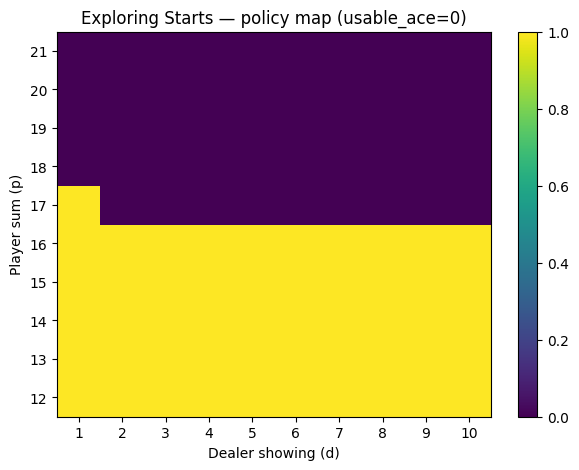

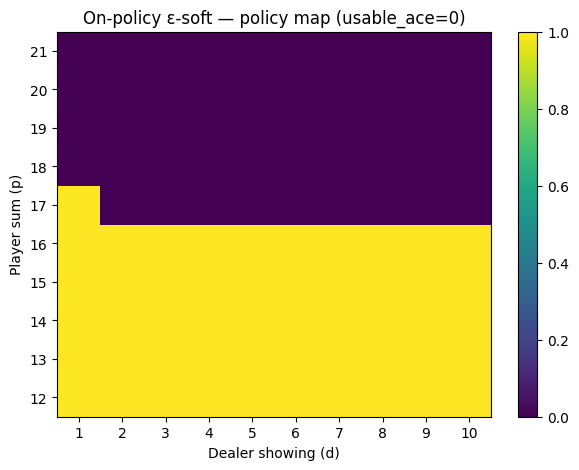

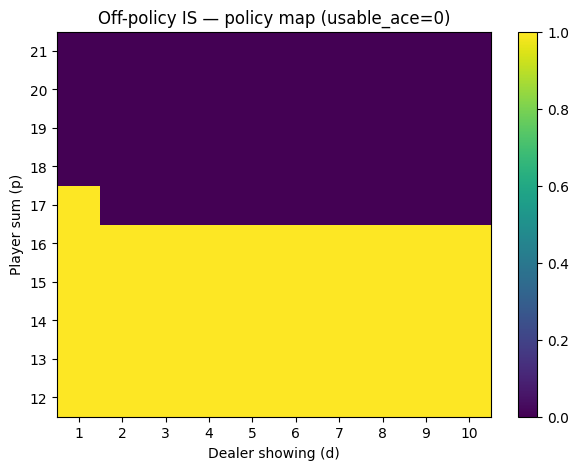

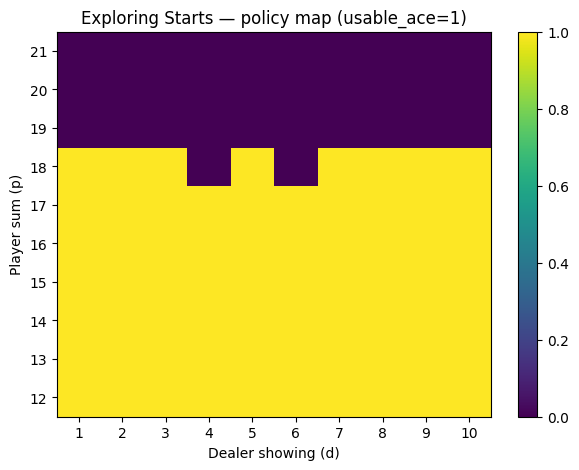

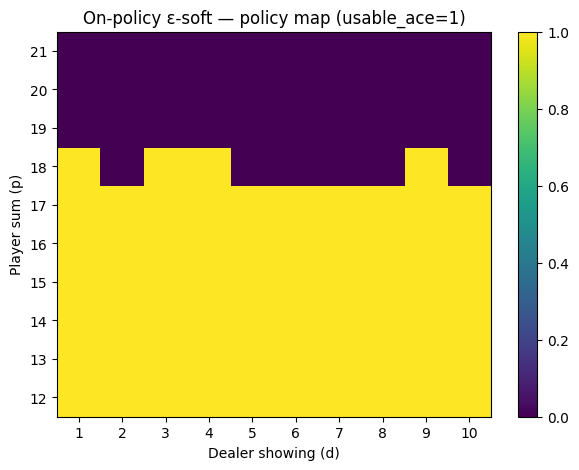

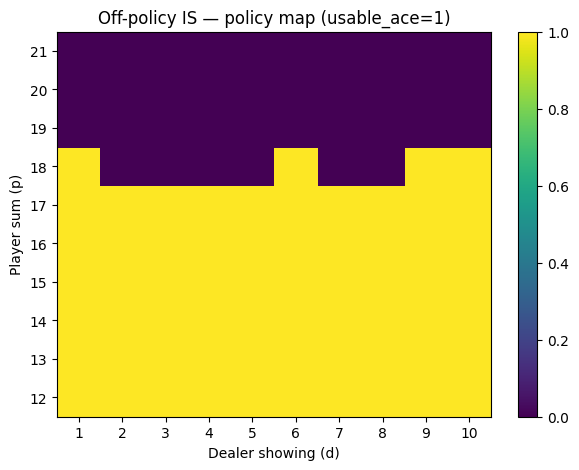

In [252]:
for usable in [0, 1]:
    for name, pi in policies.items():
        grid_pi = to_grid_from_policy(pi, usable)
        plot_policy_map(grid_pi, title=f"{name} — policy map (usable_ace={usable})")


We now perform a **quantitative comparison** of the greedy policies
learned by the different Monte Carlo control methods.

For two policies $\pi_1$ and $\pi_2$, we define the **policy agreement rate** as the
fraction of states in which both policies choose the **same action**:
$$
\text{Agreement}(\pi_1,\pi_2)
= \frac{1}{|\mathcal S|}
\sum_{s \in \mathcal S}
\mathbf{1}\{\pi_1(s) = \pi_2(s)\}.
$$

The state space considered here includes all Blackjack states with:
- player sums $p = 12,\dots,21$,
- dealer showing cards $d = 1,\dots,10$,
- both cases of usable ace ($u \in \{0,1\}$).

An agreement rate close to **1** indicates that two methods have learned **very similar policies**,
while lower values reveal systematic differences in decision-making.



In [253]:
def policy_agreement(pi_a: dict, pi_b: dict) -> float:
    """Compute agreement rate between two policies over all states.

    Args:
        pi_a: first policy dict mapping state -> action
        pi_b: second policy dict mapping state -> action

    Returns:
        agreement_rate: float in [0, 1] representing the fraction of states
                        where both policies agree on the action.

    """
    states = [(p, d, u) for u in [0, 1] for p in range(12, 22) for d in range(1, 11)]
    agree = 0
    for s in states:
        a = pi_a.get(s, HIT)
        b = pi_b.get(s, HIT)
        agree += int(a == b)
    return agree / len(states)


names = list(policies.keys())
for i in range(len(names)):
    for j in range(i + 1, len(names)):
        a, b = names[i], names[j]
        print(f"Agreement {a} vs {b}: {policy_agreement(policies[a], policies[b]):.3f}")


Agreement Exploring Starts vs On-policy ε-soft: 0.970
Agreement Exploring Starts vs Off-policy IS: 0.970
Agreement On-policy ε-soft vs Off-policy IS: 0.980


**Evaluating the Value Function of the Learned Policies**

The Monte Carlo control algorithms studied so far directly estimate **action-value functions**
$Q(s,a)$ and output a **greedy policy** $\hat{\pi}$.
However, to compare the *quality* of these learned policies, we must evaluate **how good each policy actually is**.

To do this, we perform **Monte Carlo policy evaluation** for each learned policy $\hat{\pi}$.
More precisely, for a fixed policy $\pi$, we estimate its **state-value function**:
$$
V^{\pi}(s) = \mathbb{E}_{\pi}[G \mid S_0 = s],
$$
where \( G \) denotes the terminal return of a Blackjack episode.

We use **first-visit Monte Carlo evaluation** (cf. Exercise 2. but here with another input which is the policy).


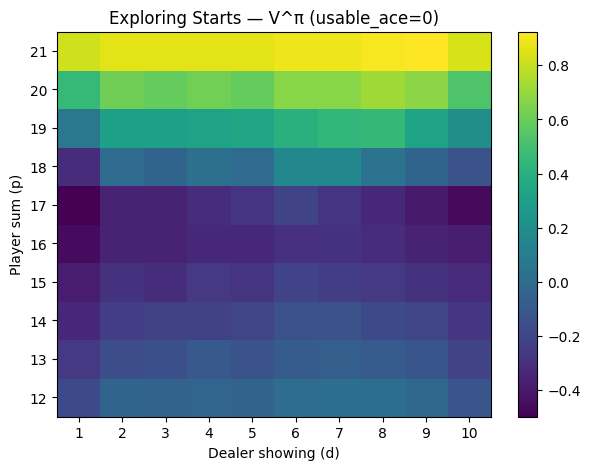

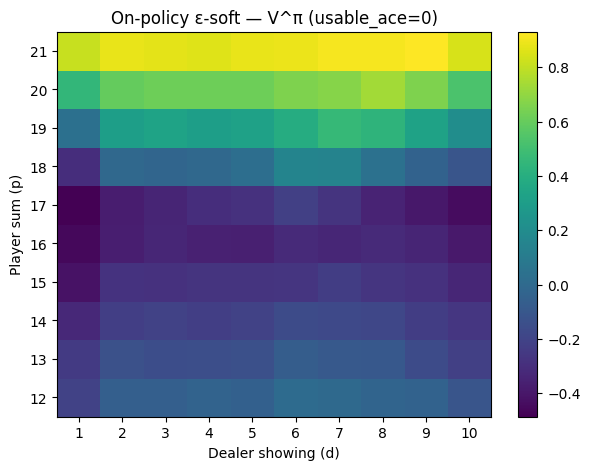

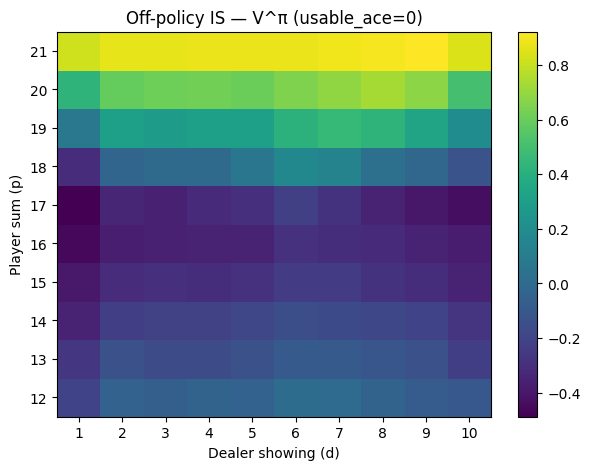

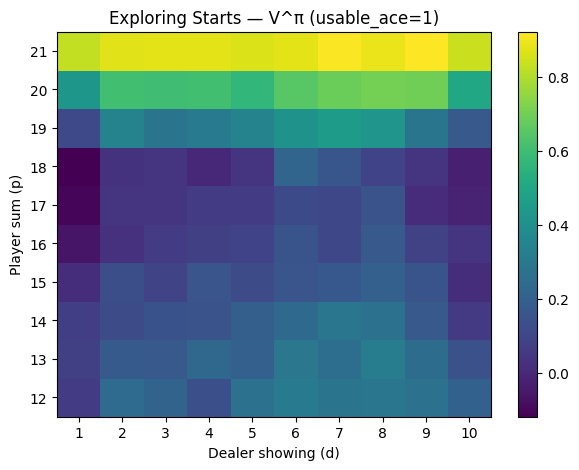

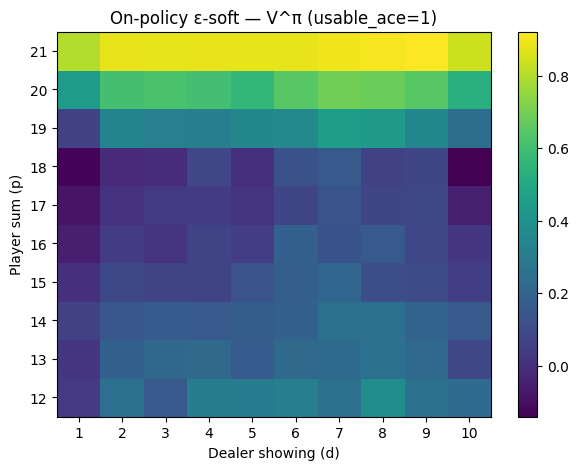

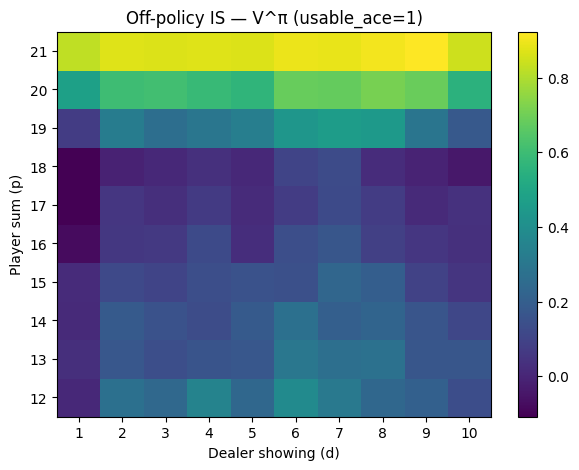

In [254]:
def mc_policy_evaluation_V(
    policy: dict, num_episodes: int = 200_000, rng: np.random.Generator = rng,
) -> dict:
    """First-visit Monte Carlo policy evaluation that estimates V^pi(s) for all visited states s.

    Args:
        policy: dict mapping state -> action
        num_episodes: number of episodes to sample
        rng: random generator used to draw cards

    Returns:
        V: dict mapping state -> estimated value

    """
    if rng is None:
        rng = np.random.default_rng(123)

    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)

    def pi(s: tuple[int, int, int]) -> int:
        """Policy function using the provided policy dict."""
        return policy.get(s, HIT)

    for _ in range(num_episodes):
        episode, G = generate_episode(pi, rng)
        visited = set()

        for s, _a in episode:
            p, _d, _u = s
            if p < 12:  # noqa: PLR2004
                continue

            if s not in visited:
                visited.add(s)
                returns_sum[s] += G
                returns_count[s] += 1

    return {s: returns_sum[s] / returns_count[s] for s in returns_sum}


rng_eval = np.random.default_rng(999)

V_of_policy = {}
for name, pi in policies.items():
    V_of_policy[name] = mc_policy_evaluation_V(pi, num_episodes=300_000, rng=rng_eval)

for usable in [0, 1]:
    for name, V in V_of_policy.items():
        grid_V = to_grid_from_V(V, usable)  # noqa: N816
        plot_value_heatmap(grid_V, title=f"{name} — V^π (usable_ace={usable})")
